In [1]:
import sys
import math
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)


In [2]:
df = pd.read_csv("Combinedhousingdata.csv")

In [3]:
df.head()

,Unnamed: 0,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated,year,month,MORTGAGE30US
0,0,2012-12-01,2012-12-31,30,place,6,18502,f,"Soledad, CA",Soledad,...,0.030488,0.600000,0.300000,0.028571,"Salinas, CA",41500,2022-07-10 14:38:00,2012,12,3.345
1,1,2020-02-01,2020-02-29,30,place,6,22758,f,"Freedom, CA",Freedom,...,NaN,1.000000,NaN,1.000000,"Santa Cruz, CA",42100,2022-07-10 14:38:00,2020,2,3.465
2,2,2021-06-01,2021-06-30,30,place,6,36263,f,"El Paso de Robles, CA",El Paso de Robles,...,NaN,NaN,NaN,NaN,"San Luis Obispo, CA",42020,2022-07-10 14:38:00,2021,6,2.975
3,3,2013-07-01,2013-07-31,30,place,6,26788,f,"Willowbrook, CA",Willowbrook,...,NaN,NaN,NaN,NaN,"Los Angeles, CA",31084,2022-07-10 14:38:00,2013,7,4.370
4,4,2015-12-01,2015-12-31,30,place,6,3843,f,"Colton, CA",Colton,...,0.033401,0.333333,-0.166667,-0.118280,"Riverside, CA",40140,2022-07-10 14:38:00,2015,12,3.964


In [4]:
df.columns

Index(['Unnamed: 0', 'period_begin', 'period_end', 'period_duration',
       'region_type', 'region_type_id', 'table_id', 'is_seasonally_adjusted',
       'region', 'city', 'state', 'state_code', 'property_type',
       'property_type_id', 'median_sale_price', 'median_sale_price_mom',
       'median_sale_price_yoy', 'median_list_price', 'median_list_price_mom',
       'median_list_price_yoy', 'median_ppsf', 'median_ppsf_mom',
       'median_ppsf_yoy', 'median_list_ppsf', 'median_list_ppsf_mom',
       'median_list_ppsf_yoy', 'homes_sold', 'homes_sold_mom',
       'homes_sold_yoy', 'pending_sales', 'pending_sales_mom',
       'pending_sales_yoy', 'new_listings', 'new_listings_mom',
       'new_listings_yoy', 'inventory', 'inventory_mom', 'inventory_yoy',
       'months_of_supply', 'months_of_supply_mom', 'months_of_supply_yoy',
       'median_dom', 'median_dom_mom', 'median_dom_yoy', 'avg_sale_to_list',
       'avg_sale_to_list_mom', 'avg_sale_to_list_yoy', 'sold_above_list',
       'so

In [5]:
columns_of_intrest = ['city', 'state', 'state_code', 'property_type', 'median_sale_price', 'median_list_price', 'median_ppsf',
                      'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'months_of_supply',
                      'median_dom', 'avg_sale_to_list', 'sold_above_list', 'price_drops', 'off_market_in_two_weeks', 
                      'parent_metro_region', 'parent_metro_region_metro_code', 'year', 'month', 'MORTGAGE30US']
df = df[columns_of_intrest]
df


,city,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,...,median_dom,avg_sale_to_list,sold_above_list,price_drops,off_market_in_two_weeks,parent_metro_region,parent_metro_region_metro_code,year,month,MORTGAGE30US
0,Soledad,California,CA,All Residential,180000.0,125800.0,102.564103,90.752462,19,10.0,...,25.0,1.003447,0.368421,0.250000,0.600000,"Salinas, CA",41500,2012,12,3.3450
1,Freedom,California,CA,Single Family Residential,477500.0,600000.0,528.221778,524.475525,2,1.0,...,14.0,1.012626,0.500000,NaN,1.000000,"Santa Cruz, CA",42100,2020,2,3.4650
2,El Paso de Robles,California,CA,Townhouse,450000.0,NaN,300.000000,NaN,1,NaN,...,3.0,1.011236,1.000000,NaN,NaN,"San Luis Obispo, CA",42020,2021,6,2.9750
3,Willowbrook,California,CA,Multi-Family (2-4 Unit),295000.0,250000.0,185.897436,175.606641,3,NaN,...,74.0,1.010053,0.666667,0.333333,NaN,"Los Angeles, CA",31084,2013,7,4.3700
4,Colton,California,CA,Single Family Residential,240000.0,229990.0,192.142857,175.259740,37,33.0,...,41.0,0.988592,0.351351,0.230769,0.333333,"Riverside, CA",40140,2015,12,3.9640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349000,Turlock,California,CA,Condo/Co-op,179000.0,289900.0,153.169014,177.501413,7,3.0,...,57.0,0.994159,0.285714,NaN,1.000000,"Modesto, CA",33700,2016,6,3.5680
349001,Modesto,California,CA,Condo/Co-op,172500.0,299000.0,159.036145,186.060983,13,11.0,...,24.0,0.982519,0.230769,0.066667,0.272727,"Modesto, CA",33700,2018,1,4.0325
349002,Vallejo,California,CA,Single Family Residential,310000.0,290000.0,197.201018,194.285714,113,98.0,...,13.0,1.021574,0.495575,0.179641,0.591837,"Vallejo, CA",46700,2015,4,3.6720
349003,Oceano,California,CA,All Residential,409900.0,269900.0,224.324324,225.872690,7,NaN,...,84.0,0.968060,0.000000,0.160000,NaN,"San Luis Obispo, CA",42020,2013,11,4.2550


In [6]:
df.describe()

,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,sold_above_list,price_drops,off_market_in_two_weeks,parent_metro_region_metro_code,year,month,MORTGAGE30US
count,3.490050e+05,3.088230e+05,3.473240e+05,3.086920e+05,349005.000000,303547.000000,308837.000000,328568.000000,328568.000000,343468.000000,348853.000000,349005.000000,246969.000000,303547.000000,349005.000000,349005.000000,349005.000000,349005.000000
mean,6.266154e+05,6.948017e+05,4.309700e+02,4.175109e+02,23.430415,24.505938,30.291594,54.660293,2.965808,60.972746,0.996315,0.355539,0.256939,0.380802,34990.377502,2016.868013,6.409948,3.809249
std,6.658542e+05,1.334131e+06,6.987570e+03,1.420956e+04,76.653873,77.577829,97.274394,186.923882,2.867542,162.284953,0.051322,0.314210,0.172107,0.293707,9586.884913,3.053384,3.417106,0.554724
min,1.000000e+00,8.500000e+02,6.896550e-04,2.833333e-01,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.500000,0.000000,0.002257,0.000000,11244.000000,2012.000000,1.000000,2.684000
25%,2.835000e+05,3.369500e+05,1.836594e+02,2.051974e+02,2.000000,2.000000,3.000000,5.000000,1.300000,18.000000,0.977104,0.000000,0.142857,0.142857,31084.000000,2014.000000,3.000000,3.460000
50%,4.525000e+05,5.190000e+05,2.913304e+02,3.144105e+02,6.000000,7.000000,9.000000,15.000000,2.100000,36.000000,0.994916,0.333333,0.220000,0.363636,40140.000000,2017.000000,6.000000,3.805000
75%,7.260000e+05,7.825000e+05,4.378262e+02,4.585214e+02,19.000000,21.000000,26.000000,47.000000,3.600000,64.000000,1.011814,0.538462,0.323944,0.555556,41740.000000,2020.000000,9.000000,4.167500
max,5.980000e+07,4.330125e+08,1.525000e+06,5.500000e+06,2981.000000,2839.000000,3584.000000,9126.000000,87.000000,20506.000000,2.000000,1.000000,1.000000,2.000000,49700.000000,2022.000000,12.000000,5.522000


In [7]:
df.isna().sum().sum()

361859

In [8]:
df.isnull().sum()/len(df)*100

city                               0.000000
state                              0.000000
state_code                         0.000000
property_type                      0.000000
median_sale_price                  0.000000
median_list_price                 11.513302
median_ppsf                        0.481655
median_list_ppsf                  11.550837
homes_sold                         0.000000
pending_sales                     13.025028
new_listings                      11.509291
inventory                          5.855790
months_of_supply                   5.855790
median_dom                         1.586510
avg_sale_to_list                   0.043552
sold_above_list                    0.000000
price_drops                       29.236257
off_market_in_two_weeks           13.025028
parent_metro_region                0.000000
parent_metro_region_metro_code     0.000000
year                               0.000000
month                              0.000000
MORTGAGE30US                    

In [9]:
missing_vals = df.isna().sum()/len(df)*100
missing_vals = missing_vals[missing_vals > 0]
print('Percentage of Missing Values:')
print(missing_vals)
print()
print('median_list_price')
print(df['median_list_price'].value_counts())

Percentage of Missing Values:
median_list_price          11.513302
median_ppsf                 0.481655
median_list_ppsf           11.550837
pending_sales              13.025028
new_listings               11.509291
inventory                   5.855790
months_of_supply            5.855790
median_dom                  1.586510
avg_sale_to_list            0.043552
price_drops                29.236257
off_market_in_two_weeks    13.025028
dtype: float64

median_list_price
699000.0     1902
599000.0     1755
499000.0     1636
799000.0     1555
399000.0     1504
             ... 
1519500.0       1
520444.0        1
1318444.0       1
6900000.0       1
767250.0        1
Name: median_list_price, Length: 16845, dtype: int64


The maximum number of house that were from city burbank,Mountain View, Spring Valley, El Cerrito and Live Oak(top5)

# Property_type feature cleaning

In [10]:
df['property_type'].value_counts()

All Residential              119509
Single Family Residential    117825
Condo/Co-op                   48786
Multi-Family (2-4 Unit)       32682
Townhouse                     30203
Name: property_type, dtype: int64

In [11]:
df['property_type'].unique()

array(['All Residential', 'Single Family Residential', 'Townhouse',
       'Multi-Family (2-4 Unit)', 'Condo/Co-op'], dtype=object)

# This feature is Categorical featire with 5 unique labels, hence we need to change this to numeric feature, for this we are using one hot encoding.

In [12]:
# performing one hot encoding 
df['property_type']=df['property_type'].replace(['All Residential'],"PropertyType_All_Residential")
df['property_type']=df['property_type'].replace(['Single Family Residential'],"PropertyType_Single_Family_Residential")
df['property_type']=df['property_type'].replace(['Townhouse'],"PropertyType_Condo/Co-op")
df['property_type']=df['property_type'].replace(['Multi-Family (2-4 Unit)'],"PropertyType_Multi-Family(2-4 Unit)")
df['property_type']=df['property_type'].replace(['Condo/Co-op'],"PropertyType_Townhouse ")
one_hot_property_type = pd.get_dummies(df['property_type'])
df = df.drop('property_type',axis = 1)
df = df.join(one_hot_property_type)

In [13]:
df.head()

,city,state,state_code,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,...,parent_metro_region,parent_metro_region_metro_code,year,month,MORTGAGE30US,PropertyType_All_Residential,PropertyType_Condo/Co-op,PropertyType_Multi-Family(2-4 Unit),PropertyType_Single_Family_Residential,PropertyType_Townhouse
0,Soledad,California,CA,180000.0,125800.0,102.564103,90.752462,19,10.0,6.0,...,"Salinas, CA",41500,2012,12,3.345,1,0,0,0,0
1,Freedom,California,CA,477500.0,600000.0,528.221778,524.475525,2,1.0,1.0,...,"Santa Cruz, CA",42100,2020,2,3.465,0,0,0,1,0
2,El Paso de Robles,California,CA,450000.0,NaN,300.000000,NaN,1,NaN,NaN,...,"San Luis Obispo, CA",42020,2021,6,2.975,0,1,0,0,0
3,Willowbrook,California,CA,295000.0,250000.0,185.897436,175.606641,3,NaN,1.0,...,"Los Angeles, CA",31084,2013,7,4.370,0,0,1,0,0
4,Colton,California,CA,240000.0,229990.0,192.142857,175.259740,37,33.0,27.0,...,"Riverside, CA",40140,2015,12,3.964,0,0,0,1,0


# Median_Sale_Price feature cleaning

In [14]:
df['median_sale_price'].value_counts()

350000.0     1727
450000.0     1708
300000.0     1578
250000.0     1574
400000.0     1552
             ... 
351455.0        1
725454.5        1
666191.0        1
1972750.0       1
197045.5        1
Name: median_sale_price, Length: 17714, dtype: int64

In [15]:
df['median_sale_price']

0         180000.0
1         477500.0
2         450000.0
3         295000.0
4         240000.0
            ...   
349000    179000.0
349001    172500.0
349002    310000.0
349003    409900.0
349004    310000.0
Name: median_sale_price, Length: 349005, dtype: float64

In [16]:
# checking for negative value in feature "median_sale_price"
(df['median_sale_price'] < 0).sum().sum()
    

0

<AxesSubplot:>

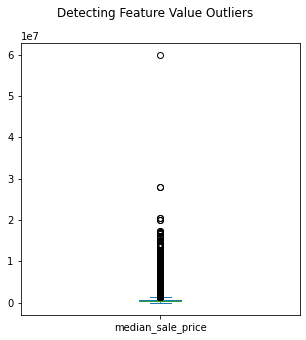

In [17]:
#box plot before removing outliers
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.suptitle('Detecting Feature Value Outliers')
#Visualize the median_sale_price
df['median_sale_price'].plot(kind="box")

In [18]:

count = 1;
min_value = sys.maxsize
max_value = -1
print(min_value)
for key, value in df['median_sale_price'].iteritems():
    if value < min_value:
      min_value = value

    if value > max_value:
      max_value = value
    
print(min_value)
print(max_value)

9223372036854775807
1.0
59800000.0


In [19]:
#checking for how many value outliers dropped
median_sale_price_df=df['median_sale_price']
value=1389750.0
#maximum value after removing outliers
count=0
for i, number in df['median_sale_price'].iteritems():
    if number > value:
        count=count+1
print(count)
#Percentage of outliers dropped
print("Percentage of outliers dropped",str((count*100)/df['median_sale_price'].shape[0])) 

26827
Percentage of outliers dropped 7.686709359464764


# median_list_price feature cleaning

In [20]:
df['median_list_price'].value_counts()

699000.0     1902
599000.0     1755
499000.0     1636
799000.0     1555
399000.0     1504
             ... 
1519500.0       1
520444.0        1
1318444.0       1
6900000.0       1
767250.0        1
Name: median_list_price, Length: 16845, dtype: int64

In [21]:
df['median_list_price'].unique()

array([125800. , 600000. ,      nan, ..., 292950. , 522388.5, 397800. ])

In [22]:
#checking for missing value 
missing_vals2 = df['median_list_price'].isna().sum()/len(df['median_sale_price'])*100
missing_vals2

11.513302101689089

In [23]:
# checking for negative value in feature "median_sale_price"
(df['median_list_price'] < 0).sum().sum()

0

In [24]:
#pip install missingno

<AxesSubplot:>

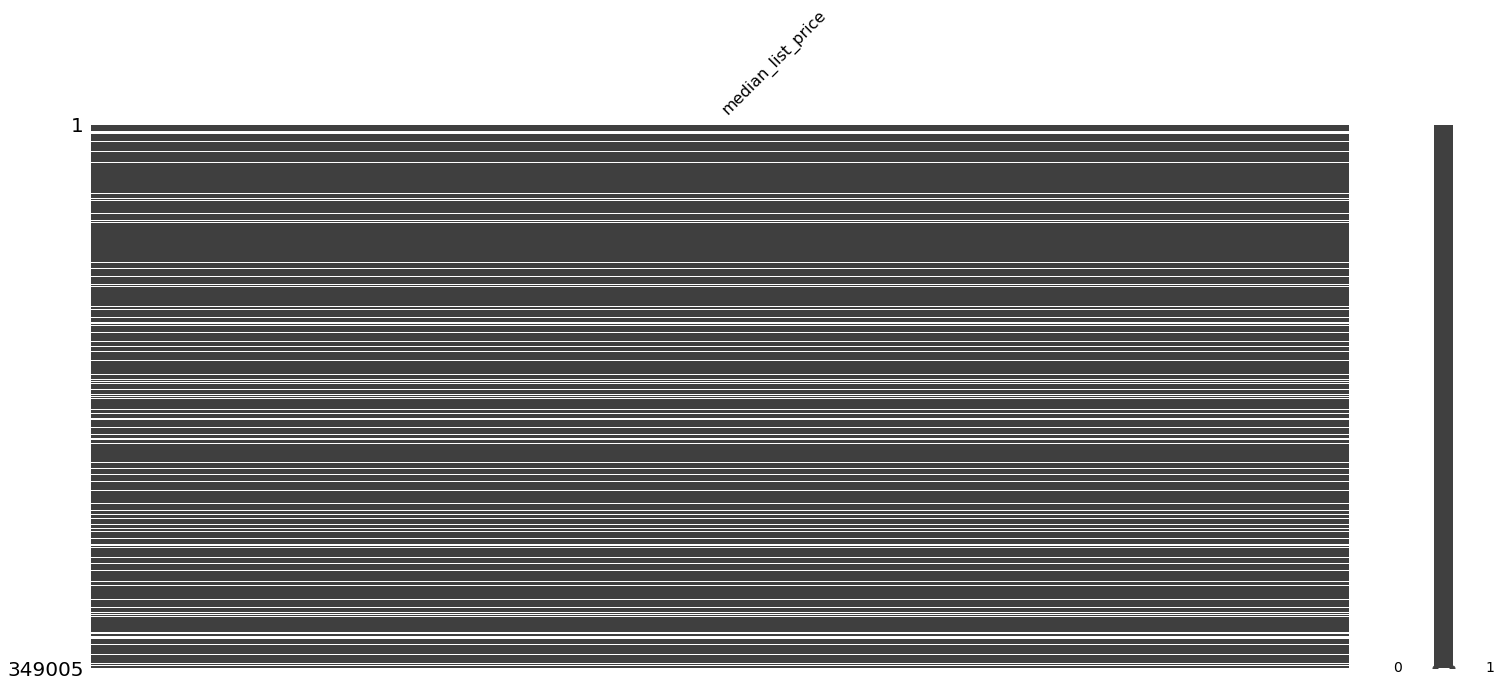

In [25]:
test=df[['median_list_price']]
msno.matrix(test)

We can see that data is missing through out the instances ( The NA values are not back to back only at the tail or in the middle of the dataset)

In [26]:
# Imputing median_list_price with its Mean as we can't perform other technique such as KNN as we are considering to keep the outlier for this feature 
df['median_list_price'].fillna(df['median_list_price'].mean(), inplace = True)

In [27]:
missing_vals2 = df['median_list_price'].isna().sum()/len(df['median_sale_price'])*100
missing_vals2

0.0

In [28]:

count = 1;
min_value = sys.maxsize
max_value = -1
print(min_value)
for key, value in df['median_list_price'].iteritems():
    if value < min_value:
      min_value = value

    if value > max_value:
      max_value = value
    
print("Minimum value", min_value)
print("Maximum value", max_value)

9223372036854775807
Minimum value 850.0
Maximum value 433012500.0


In [29]:
#checking for how many value outliers dropped
median_list_price_df=df['median_list_price']
value=1150000.0
#maximum value after removing outliers
count=0
for i, number in df['median_list_price'].iteritems():
    if number > value:
        count=count+1
print(count)
#Percentage of outliers dropped
print("Percentage of outliers dropped",str((count*100)/df['median_list_price'].shape[0])) 

38290
Percentage of outliers dropped 10.97118952450538


<AxesSubplot:>

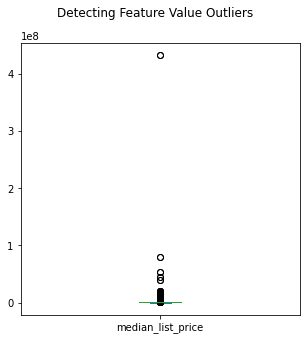

In [30]:
#checking for outliers
#box plot before removing outliers
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.suptitle('Detecting Feature Value Outliers')
#Visualize the median_list_ppsf
df['median_list_price'].plot(kind="box")

In [31]:

count = 1;
min_value = sys.maxsize
max_value = -1
print(min_value)
for key, value in df['median_list_price'].iteritems():
    if value < min_value:
      min_value = value

    if value > max_value:
      max_value = value
    
print("Minimum value", min_value)
print("Maximum value", max_value)

9223372036854775807
Minimum value 850.0
Maximum value 433012500.0


<AxesSubplot:ylabel='Density'>

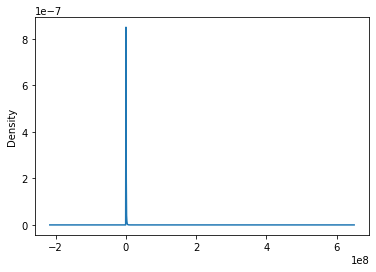

In [32]:
df['median_list_price'].plot(kind='kde')

# median_ppsf feature cleaning

In [33]:
df['median_ppsf'].value_counts()

250.000000    232
333.333333    145
500.000000    142
125.000000    142
166.666667    134
             ... 
407.671722      1
341.378888      1
164.934478      1
301.425056      1
159.036145      1
Name: median_ppsf, Length: 234806, dtype: int64

In [34]:
df['median_ppsf'].unique()

array([102.5641026, 528.2217782, 300.       , ..., 591.9953186,
       153.1690141, 159.0361446])

In [35]:
#checking for negative value for this feature
(df['median_ppsf']<0).sum().sum()

0

In [36]:
count = 1;
min_value = sys.maxsize
max_value = -1
print(min_value)
for key, value in df['median_ppsf'].iteritems():
    if value < min_value:
      min_value = value

    if value > max_value:
      max_value = value
    
print("Minimum value", min_value)
print("Maximum value", max_value)

9223372036854775807
Minimum value 0.000689655
Maximum value 1525000.0


<AxesSubplot:>

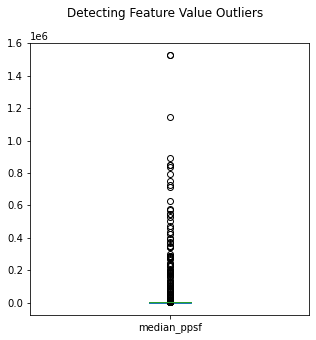

In [37]:
#checking for outliers
#box plot before removing outliers
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.suptitle('Detecting Feature Value Outliers')
#Visualize the median_list_ppsf
df['median_ppsf'].plot(kind="box")

# median_list_ppsf feature cleaning

In [38]:
df['median_list_ppsf'].value_counts()

250.000000    144
312.500000    128
500.000000     96
166.666667     77
333.333333     60
             ... 
308.054577      1
493.323442      1
220.716515      1
774.160448      1
496.331536      1
Name: median_list_ppsf, Length: 103519, dtype: int64

In [39]:
#checking for negative value for this feature
(df['median_list_ppsf']<0).sum().sum()

0

<AxesSubplot:>

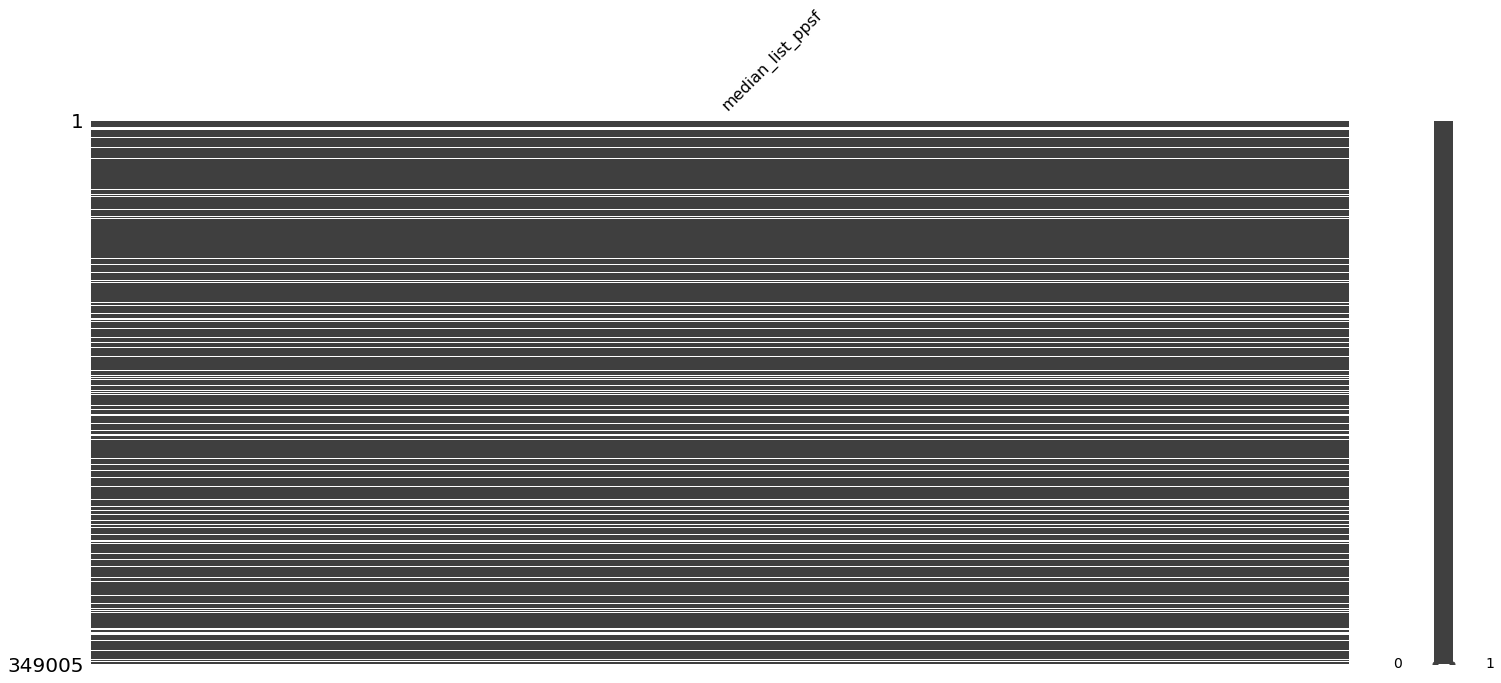

In [40]:

test=df[['median_list_ppsf']]
msno.matrix(test)

Same justification for this as mentioned for abive feature

<AxesSubplot:>

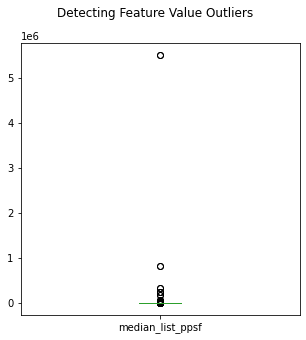

In [41]:
#checking for outliers
#box plot before removing outliers
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.suptitle('Detecting Feature Value Outliers')
#Visualize the median_list_ppsf
df['median_list_ppsf'].plot(kind="box")

In [42]:
count = 1;
min_value = sys.maxsize
max_value = -1
print(min_value)
for key, value in df['median_list_ppsf'].iteritems():
    if value < min_value:
      min_value = value

    if value > max_value:
      max_value = value
    
print("Minimum value", min_value)
print("Maximum value", max_value)

9223372036854775807
Minimum value 0.283333333
Maximum value 5500000.0


this is certainly an outlier because this is about median per square feet for listed house and max value is 5500000.0

In [43]:
df.shape

(349005, 27)

In [44]:
# Fix the index to be in order
df.reset_index(inplace=True)
df.drop('index', axis= 1, inplace=True)

In [45]:
df.head()

,city,state,state_code,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,...,parent_metro_region,parent_metro_region_metro_code,year,month,MORTGAGE30US,PropertyType_All_Residential,PropertyType_Condo/Co-op,PropertyType_Multi-Family(2-4 Unit),PropertyType_Single_Family_Residential,PropertyType_Townhouse
0,Soledad,California,CA,180000.0,125800.00000,102.564103,90.752462,19,10.0,6.0,...,"Salinas, CA",41500,2012,12,3.345,1,0,0,0,0
1,Freedom,California,CA,477500.0,600000.00000,528.221778,524.475525,2,1.0,1.0,...,"Santa Cruz, CA",42100,2020,2,3.465,0,0,0,1,0
2,El Paso de Robles,California,CA,450000.0,694801.66751,300.000000,NaN,1,NaN,NaN,...,"San Luis Obispo, CA",42020,2021,6,2.975,0,1,0,0,0
3,Willowbrook,California,CA,295000.0,250000.00000,185.897436,175.606641,3,NaN,1.0,...,"Los Angeles, CA",31084,2013,7,4.370,0,0,1,0,0
4,Colton,California,CA,240000.0,229990.00000,192.142857,175.259740,37,33.0,27.0,...,"Riverside, CA",40140,2015,12,3.964,0,0,0,1,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349005 entries, 0 to 349004
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   city                                    349005 non-null  object 
 1   state                                   349005 non-null  object 
 2   state_code                              349005 non-null  object 
 3   median_sale_price                       349005 non-null  float64
 4   median_list_price                       349005 non-null  float64
 5   median_ppsf                             347324 non-null  float64
 6   median_list_ppsf                        308692 non-null  float64
 7   homes_sold                              349005 non-null  int64  
 8   pending_sales                           303547 non-null  float64
 9   new_listings                            308837 non-null  float64
 10  inventory                               3285

# City Feature cleaning

In [47]:
df['city'].value_counts()

Burbank          911
Mountain View    863
Spring Valley    712
El Cerrito       700
Live Oak         682
                ... 
Edwards AFB        2
Essex              2
Sugarloaf          2
Westside           2
Industry           2
Name: city, Length: 1335, dtype: int64

In [48]:
len(df['city'].str.lower().unique())

1335

In [49]:
df['city'].str.lower()

0                   soledad
1                   freedom
2         el paso de robles
3               willowbrook
4                    colton
                ...        
349000              turlock
349001              modesto
349002              vallejo
349003               oceano
349004             rio dell
Name: city, Length: 349005, dtype: object

In [50]:
# performing labelencoding on city column
label_city = LabelEncoder()
df['city']=label_city.fit_transform(df['city'])
# df = df.drop('city',axis = 1)
# df = df.join(one_hot_city)

In [51]:
print(df['city'].unique())

[1124  426  360 ... 1145   64  536]


# State,parent_metro_region and state_code cleaning

In [52]:
#performing one hot encoding on state column
one_hot_state = pd.get_dummies(df['state'])
one_hot_state_code = pd.get_dummies(df['state_code'])
df = df.drop('state',axis = 1)
df = df.drop('state_code',axis = 1)
df = df.join(one_hot_state_code)
df = df.join(one_hot_state)


In [53]:
df['parent_metro_region'].unique()


array(['Salinas, CA', 'Santa Cruz, CA', 'San Luis Obispo, CA',
       'Los Angeles, CA', 'Riverside, CA', 'Santa Rosa, CA',
       'Sacramento, CA', 'Oakland, CA', 'Vallejo, CA', 'Eureka, CA',
       'Fresno, CA', 'Anaheim, CA', 'Truckee, CA', 'Oxnard, CA',
       'San Francisco, CA', 'San Diego, CA', 'Santa Maria, CA',
       'Merced, CA', 'Visalia, CA', 'Madera, CA', 'Yuba City, CA',
       'Stockton, CA', 'Chico, CA', 'Napa, CA', 'Clearlake, CA',
       'Ukiah, CA', 'Bakersfield, CA', 'San Rafael, CA', 'Modesto, CA',
       'San Jose, CA', 'Hanford, CA', 'Redding, CA', 'Red Bluff, CA',
       'El Centro, CA', 'Sonora, CA', 'Susanville, CA'], dtype=object)

In [54]:
# split  Parent metro region into metro region and drop CA
df["parent_metro_region"] = df["parent_metro_region"].str.replace(r',[^,]*$', '')

C:\Users\saumy\AppData\Local\Temp\ipykernel_19668\3707997030.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["parent_metro_region"] = df["parent_metro_region"].str.replace(r',[^,]*$', '')


In [55]:
df['parent_metro_region'].unique()

array(['Salinas', 'Santa Cruz', 'San Luis Obispo', 'Los Angeles',
       'Riverside', 'Santa Rosa', 'Sacramento', 'Oakland', 'Vallejo',
       'Eureka', 'Fresno', 'Anaheim', 'Truckee', 'Oxnard',
       'San Francisco', 'San Diego', 'Santa Maria', 'Merced', 'Visalia',
       'Madera', 'Yuba City', 'Stockton', 'Chico', 'Napa', 'Clearlake',
       'Ukiah', 'Bakersfield', 'San Rafael', 'Modesto', 'San Jose',
       'Hanford', 'Redding', 'Red Bluff', 'El Centro', 'Sonora',
       'Susanville'], dtype=object)

In [56]:
one_hot_parent_metro_region = pd.get_dummies(df['parent_metro_region'])
df = df.drop('parent_metro_region' ,axis=1)
df = df.join(one_hot_parent_metro_region)

In [57]:
df.head(5)

,city,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,...,Santa Maria,Santa Rosa,Sonora,Stockton,Susanville,Truckee,Ukiah,Vallejo,Visalia,Yuba City
0,1124,180000.0,125800.00000,102.564103,90.752462,19,10.0,6.0,16.0,0.8,...,0,0,0,0,0,0,0,0,0,0
1,426,477500.0,600000.00000,528.221778,524.475525,2,1.0,1.0,1.0,0.5,...,0,0,0,0,0,0,0,0,0,0
2,360,450000.0,694801.66751,300.000000,NaN,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1306,295000.0,250000.00000,185.897436,175.606641,3,NaN,1.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,241,240000.0,229990.00000,192.142857,175.259740,37,33.0,27.0,65.0,1.8,...,0,0,0,0,0,0,0,0,0,0


# 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'months_of_supply',  'avg_sale_to_list', 'sold_above_list', 'price_drops', 'off_market_in_two_weeks features cleaning

In [58]:
df['homes_sold'].value_counts()

1       66564
2       38857
3       27451
4       20749
5       16535
        ...  
1027        1
685         1
1405        1
2064        1
597         1
Name: homes_sold, Length: 1197, dtype: int64

In [59]:
#checking for negative value for this feature # checked for each of these features and got zero in results
col=['homes_sold','pending_sales','new_listings','inventory','months_of_supply','avg_sale_to_list','sold_above_list','price_drops','off_market_in_two_weeks']
(df[col]<0).sum().sum()

0

In [60]:
col=['homes_sold','pending_sales','new_listings','inventory','months_of_supply','avg_sale_to_list','sold_above_list','price_drops','off_market_in_two_weeks']
(df[col]<0).sum().sum()
missing_vals2 = df[col].isna().sum()/len(df[col])*100
missing_vals2

homes_sold                  0.000000
pending_sales              13.025028
new_listings               11.509291
inventory                   5.855790
months_of_supply            5.855790
avg_sale_to_list            0.043552
sold_above_list             0.000000
price_drops                29.236257
off_market_in_two_weeks    13.025028
dtype: float64

<AxesSubplot:>

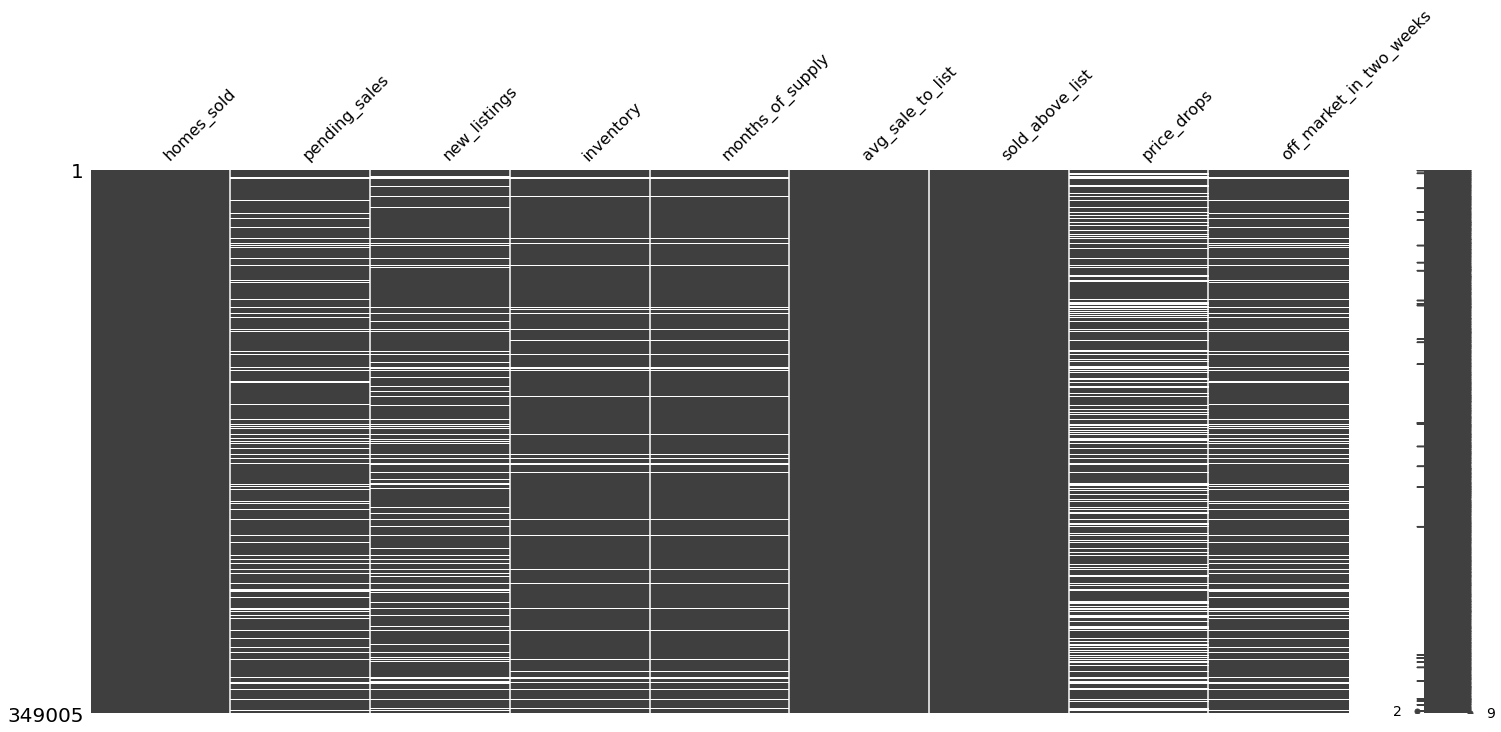

In [61]:
col=['homes_sold','pending_sales','new_listings','inventory','months_of_supply','avg_sale_to_list','sold_above_list','price_drops','off_market_in_two_weeks']
test=df[col]
msno.matrix(test)

<AxesSubplot:>

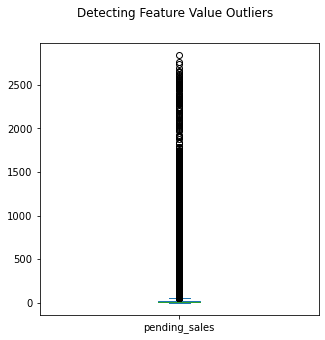

In [62]:
#checking for outliers
#box plot before removing outliers
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.suptitle('Detecting Feature Value Outliers')
#Visualize the median_list_ppsf
df['pending_sales'].plot(kind="box")

In [63]:
Q1 = df['pending_sales'].quantile(0.25)
Q3 = df['pending_sales'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['pending_sales'] < (Q1 - 1.5 * IQR)) |(df['pending_sales'] > (Q3 + 1.5* IQR)))]

In [64]:
df['pending_sales'].fillna(df['pending_sales'].mean(), inplace = True)


In [65]:
df['new_listings'].fillna(df['new_listings'].mean(), inplace = True)


In [66]:
df['inventory'].fillna(df['inventory'].mean(), inplace = True)

In [67]:
df['months_of_supply'].fillna(df['months_of_supply'].mean(), inplace = True)

In [68]:
df['price_drops'].fillna(df['price_drops'].mean(), inplace = True)

In [69]:
df['off_market_in_two_weeks'].fillna(df['off_market_in_two_weeks'].mean(), inplace = True)

In [70]:
df['median_dom'].fillna(df['median_dom'].mean(), inplace = True)

In [71]:
df['median_ppsf'].fillna(df['median_ppsf'].mean(), inplace = True)

In [72]:
df['median_list_ppsf'].fillna(df['median_list_ppsf'].mean(), inplace = True)

In [73]:
df['avg_sale_to_list'].fillna(df['avg_sale_to_list'].mean(), inplace = True)

<AxesSubplot:>

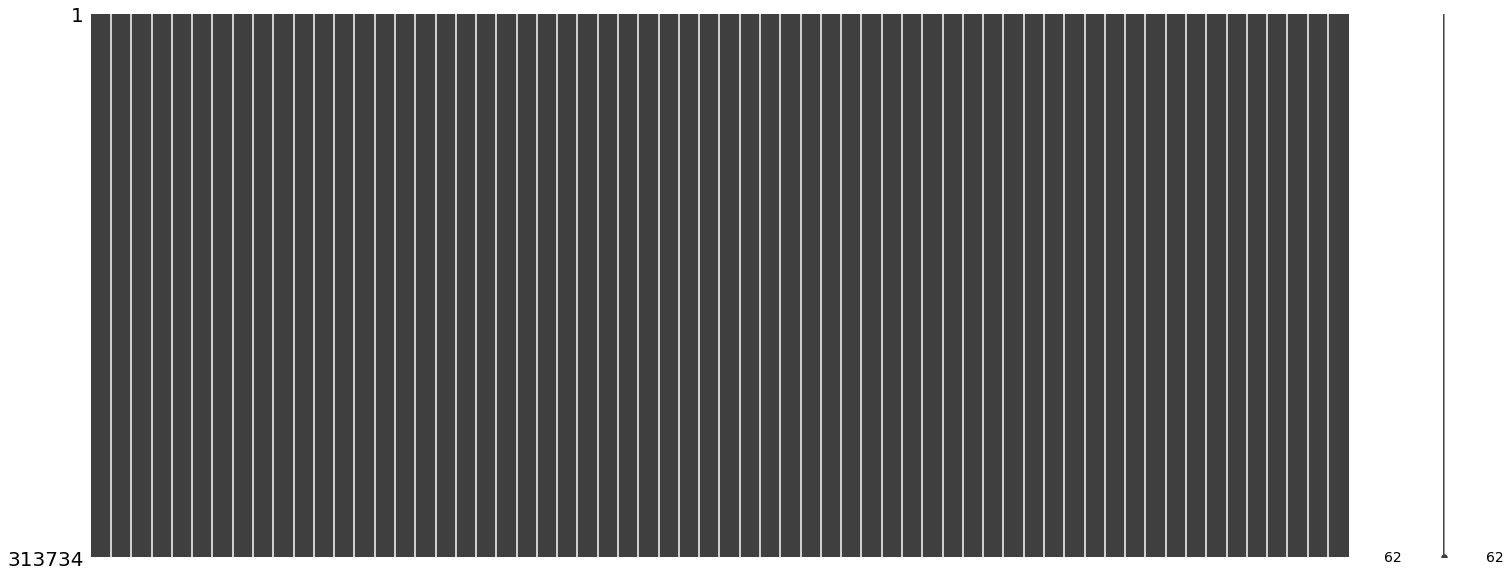

In [74]:
msno.matrix(df)

In [75]:
missing_vals2 = df[col].isna().sum()/len(df[col])*100
missing_vals2

homes_sold                 0.0
pending_sales              0.0
new_listings               0.0
inventory                  0.0
months_of_supply           0.0
avg_sale_to_list           0.0
sold_above_list            0.0
price_drops                0.0
off_market_in_two_weeks    0.0
dtype: float64

In [76]:
# # Normalize Distance and Age
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# cols_to_norm = ['median_sale_price', 'median_list_price', 'median_ppsf','median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'months_of_supply', 'avg_sale_to_list', 'sold_above_list', 'price_drops', 'off_market_in_two_weeks','MORTGAGE30US']
# df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])

In [77]:
cols = ['median_sale_price', 'median_list_price', 'median_ppsf', 'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'months_of_supply','avg_sale_to_list', 'sold_above_list', 'price_drops'] # one or more

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Baseline Model

In [78]:
df['median_dom'].value_counts()

64.396464      3888
14.000000      2878
11.000000      2876
10.000000      2851
12.000000      2836
               ... 
893.000000        1
948.000000        1
662.000000        1
712.000000        1
2141.000000       1
Name: median_dom, Length: 1108, dtype: int64

In [79]:
#checking for negative value for this feature
(df['median_dom']<0).sum().sum()

0

<AxesSubplot:>

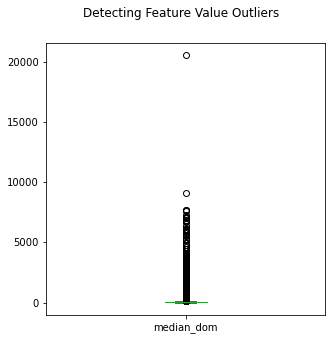

In [80]:
#checking for outliers
#box plot before removing outliers
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.suptitle('Detecting Feature Value Outliers')
#Visualize the median_list_ppsf
df['median_dom'].plot(kind="box")

In [81]:
Q1 = df['median_dom'].quantile(0.25)
Q3 = df['median_dom'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['median_dom'] < (Q1 - 1.5 * IQR)) |(df['median_dom'] > (Q3 + 1.5* IQR)))]

<AxesSubplot:>

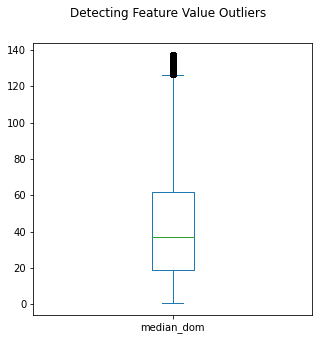

In [82]:
#checking for outliers
#box plot before removing outliers
fig, axes = plt.subplots(1, 1, figsize=(5,5))
fig.suptitle('Detecting Feature Value Outliers')
#Visualize the median_list_ppsf
df['median_dom'].plot(kind="box")

In [83]:
df['median_dom'].shape

(156524,)

In [84]:
df['median_dom'].fillna(df['median_dom'].mean(), inplace = True)

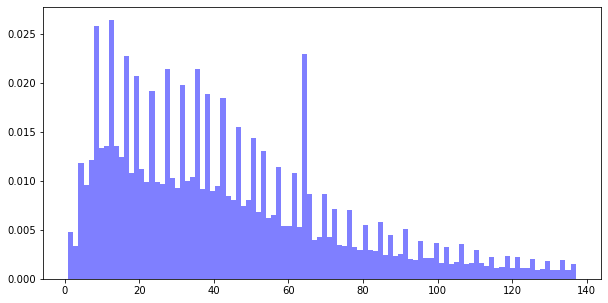

In [85]:
fig=plt.figure(figsize=(10,5))
plt.hist(df['median_dom'], bins=100, density=True, alpha=0.5, color='b')
  
plt.show()

In [86]:
df['median_dom'] = np.round(df['median_dom'], decimals = 1)

In [87]:
df.columns

Index(['city', 'median_sale_price', 'median_list_price', 'median_ppsf',
       'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'months_of_supply', 'median_dom', 'avg_sale_to_list',
       'sold_above_list', 'price_drops', 'off_market_in_two_weeks',
       'parent_metro_region_metro_code', 'year', 'month', 'MORTGAGE30US',
       'PropertyType_All_Residential', 'PropertyType_Condo/Co-op',
       'PropertyType_Multi-Family(2-4 Unit)',
       'PropertyType_Single_Family_Residential', 'PropertyType_Townhouse ',
       'CA', 'California', 'Anaheim', 'Bakersfield', 'Chico', 'Clearlake',
       'El Centro', 'Eureka', 'Fresno', 'Hanford', 'Los Angeles', 'Madera',
       'Merced', 'Modesto', 'Napa', 'Oakland', 'Oxnard', 'Red Bluff',
       'Redding', 'Riverside', 'Sacramento', 'Salinas', 'San Diego',
       'San Francisco', 'San Jose', 'San Luis Obispo', 'San Rafael',
       'Santa Cruz', 'Santa Maria', 'Santa Rosa', 'Sonora', 'Stockton',
       'Susanville

In [88]:
df['median_dom'].describe()

count    156524.000000
mean         43.240278
std          30.098821
min           1.000000
25%          19.000000
50%          37.000000
75%          62.000000
max         137.000000
Name: median_dom, dtype: float64

We have used apply() on the entire row of the dataframe and among all, we have taken onyl median_dom

In [89]:
def assign_quality(row):
    if row['median_dom'] <= 21: #3 weeks...
        return 0
    elif row['median_dom'] > 21 and row['median_dom'] <= 45: #3 weeks to 1.5 months...
        return 1
    else: # greater than 1.5 months...
        return 2

In [90]:
df['quality'] = df.apply(assign_quality, axis=1)

In [91]:
df1 = df[['median_dom', 'quality']]

In [92]:
df1['quality'].unique()

array([1, 0, 2], dtype=int64)

In [93]:
df1['quality'].value_counts()

2    61816
1    49530
0    45178
Name: quality, dtype: int64

In [94]:
df.reset_index(inplace=True)
df.drop('index', axis= 1, inplace=True)

In [95]:
# df['quality_Ranking'] = 0
# for i in range(len(df)):
#     if df['quality'][i] == 'HIGH':
#         df['quality_Ranking'][i] = 1
#     elif df['quality'][i] == 'MEDIUM':
#         df['quality_Ranking'][i] = 2
#     else :
#         df['quality_Ranking'][i]=3


In [96]:
df.head()

,city,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,...,Santa Rosa,Sonora,Stockton,Susanville,Truckee,Ukiah,Vallejo,Visalia,Yuba City,quality
0,1124,180000.0,125800.00000,102.564103,90.752462,19,10.000000,6.000000,16.000000,0.800000,...,0,0,0,0,0,0,0,0,0,1
1,426,477500.0,600000.00000,528.221778,524.475525,2,1.000000,1.000000,1.000000,0.500000,...,0,0,0,0,0,0,0,0,0,0
2,360,450000.0,694801.66751,300.000000,428.895978,1,10.026163,12.991399,26.321098,3.077924,...,0,0,0,0,0,0,0,0,0,0
3,1306,295000.0,250000.00000,185.897436,175.606641,3,10.026163,1.000000,3.000000,1.000000,...,0,0,0,0,0,0,0,0,0,2
4,487,895000.0,579900.00000,382.910117,285.946746,3,3.000000,1.000000,1.000000,0.300000,...,0,0,0,0,0,0,1,0,0,1


In [97]:
df['quality']

0         1
1         0
2         0
3         2
4         1
         ..
156519    0
156520    2
156521    1
156522    2
156523    2
Name: quality, Length: 156524, dtype: int64

In [98]:
df.describe()

,city,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,...,Santa Rosa,Sonora,Stockton,Susanville,Truckee,Ukiah,Vallejo,Visalia,Yuba City,quality
count,156524.000000,1.565240e+05,1.565240e+05,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,...,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000
mean,660.952525,4.509800e+05,5.368205e+05,289.700471,326.949167,6.522399,6.843201,8.776842,16.238133,2.513943,...,0.032545,0.000645,0.023760,0.000460,0.009915,0.000882,0.010427,0.009673,0.011628,1.106297
std,382.638095,2.597280e+05,2.466166e+05,147.153848,139.045113,5.927019,5.122658,6.604462,14.073726,1.505890,...,0.177442,0.025394,0.152301,0.021443,0.099082,0.029680,0.101577,0.097873,0.107203,0.819920
min,0.000000,1.000000e+00,1.500000e+03,0.000690,0.771605,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,338.000000,2.600000e+05,3.450000e+05,175.507020,213.939230,2.000000,2.000000,3.000000,5.000000,1.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,654.000000,4.010000e+05,5.300000e+05,269.406849,329.274404,4.000000,6.000000,7.000000,12.000000,2.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,999.000000,5.900000e+05,6.948017e+05,382.375857,428.895978,9.000000,10.026163,12.991399,26.321098,3.077924,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1334.000000,1.418000e+06,1.320500e+06,832.376579,760.512622,29.000000,23.000000,33.000000,65.000000,7.300000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [99]:
#Perform normalization on non one hot encoding columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
col=['median_sale_price', 'median_list_price', 'median_ppsf',
       'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'months_of_supply', 'median_dom', 'avg_sale_to_list',
       'sold_above_list', 'price_drops', 'off_market_in_two_weeks']



df[col] = scaler.fit_transform(df[col])

In [100]:
one_hot_parent_metro_region_metro_code = pd.get_dummies(df['parent_metro_region_metro_code'])
df = df.drop('parent_metro_region_metro_code' ,axis=1)
df = df.join(one_hot_parent_metro_region_metro_code)

In [101]:
df.describe()

,city,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,...,42200,42220,43760,44700,45000,46020,46380,46700,47300,49700
count,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,...,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000,156524.000000
mean,660.952525,0.318039,0.405853,0.348040,0.429327,0.197229,0.265600,0.243026,0.238096,0.344376,...,0.016279,0.032545,0.000645,0.023760,0.000460,0.009915,0.000882,0.010427,0.009673,0.011628
std,382.638095,0.183165,0.186972,0.176788,0.183016,0.211679,0.232848,0.206389,0.219902,0.206286,...,0.126545,0.177442,0.025394,0.152301,0.021443,0.099082,0.029680,0.101577,0.097873,0.107203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,338.000000,0.183356,0.260425,0.210850,0.280579,0.035714,0.045455,0.062500,0.062500,0.178082,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,654.000000,0.282792,0.400682,0.323659,0.432388,0.107143,0.227273,0.187500,0.171875,0.315068,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,999.000000,0.416079,0.525627,0.459378,0.563514,0.285714,0.410280,0.374731,0.395642,0.421633,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1334.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [103]:
y = df['quality']
X = df.drop('quality',axis=1)
#, x_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) # 0.25 x 0.8 = 0.2

In [104]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(len(y_val))
print(len(X_val))

126783
15653
126783
15653
14088
14088


logistic regression predicts if something is true or false,curve goes from 0 to1 and it tells the probability and is usally used for classification problem

In [105]:
model = LogisticRegression()

In [106]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\saumy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [107]:
from sklearn.metrics import classification_report

In [108]:
#print(classification_report(y_test,y_pred))

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.62      0.62      4486
           1       0.51      0.45      0.48      4997
           2       0.71      0.79      0.74      6170

    accuracy                           0.63     15653
   macro avg       0.62      0.62      0.62     15653
weighted avg       0.62      0.63      0.63     15653



In [110]:
model.fit(X_train,y_train)
y_pred = model.predict(X_val)


C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\saumy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [111]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      4029
           1       0.50      0.46      0.48      4446
           2       0.73      0.79      0.75      5613

    accuracy                           0.63     14088
   macro avg       0.62      0.62      0.62     14088
weighted avg       0.63      0.63      0.63     14088




# Performing feature reduction using PCA

In [112]:
from sklearn.decomposition import PCA

In [114]:
pca = PCA(n_components = 18)
pca.fit(X_train)
variance = pca.explained_variance_ratio_

C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [115]:
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [116]:
print(len(X_train_reduced))
print(len(X_test_reduced))
print(len(y_train))
print(len(y_test))
print(len(y_val))
print(len(X_val))

126783
15653
126783
15653
14088
14088


In [117]:
pca.explained_variance_ratio_.sum()

0.9999935370813446

In [118]:
#Fitting Logistic Regression to the Training set
model.fit(X_train_reduced, y_train)
#Predicting the Test set results
y_pred = model.predict(X_test_reduced)

C:\Users\saumy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [119]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.52      0.54      4486
           1       0.50      0.35      0.41      4997
           2       0.58      0.74      0.65      6170

    accuracy                           0.55     15653
   macro avg       0.54      0.54      0.53     15653
weighted avg       0.55      0.55      0.54     15653



In [120]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [121]:

lasso = Lasso(alpha=1.0)

In [122]:
lasso.fit(X_train, y_train)

C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Lasso()

In [123]:
lasso.score(X_test, y_test)
print(lasso.score(X_test, y_test))
print(lasso.score(X_train, y_train))


9.528942473946422e-05
0.00010191904363421322


C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\saumy\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [124]:
Ridge=Ridge(alpha=1.0)